# Klasyfikator Decision Tree do klasyfikacji samogłosek

## klasyfikacja na podstawie częstotliwości podstawowej f0 i czterech formantów f1, f2, f3 i f4 - z zastosowaniem selekcji cech

Import niezbędnych bibliotek

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

Wczytanie zbioru danych

In [10]:
# Wczytanie zbioru danych
dane = pd.read_csv('data.csv')
print(dane)

     Unnamed: 0 vowel  sex          f0       form1        form2        form3  \
0             0     a    1  204.081633  315.948937  1263.413590  1276.537740   
1             1     a    1  196.078431  242.712410   805.882072  1374.298616   
2             2     a    1  196.078431  217.568989  1028.162184  1497.574134   
3             3     a    1  192.307692  231.209209  1085.102842  1496.766417   
4             4     a    1  192.307692  234.594628  1034.159946  1475.186939   
..          ...   ...  ...         ...         ...          ...          ...   
115         115     y    0  140.845070  303.013981   646.618834  1541.130316   
116         116     y    0  140.845070  287.549398   672.236633  1529.768064   
117         117     y    0  138.888889    0.000000     0.000000   265.970918   
118         118     y    0  138.888889  235.339449   525.554358  1440.605228   
119         119     y    0  135.135135  230.090860   619.243258  1665.573217   

           form4  
0    2647.008730  
1

Posortowanie zbioru danych według samogłosek. Mamy po 20 próbek dla każdej z 6 samogłosek.

In [11]:
dane = dane.sort_values('vowel')
print(dane)

     Unnamed: 0 vowel  sex          f0       form1        form2        form3  \
0             0     a    1  204.081633  315.948937  1263.413590  1276.537740   
64           64     a    0  158.730159    0.000000     0.000000   625.723402   
65           65     a    0  147.058824    0.000000     0.000000   585.885056   
66           66     a    0  147.058824   57.147870   547.790667  1226.394104   
67           67     a    0  142.857143  250.250064   896.375921  1150.711714   
..          ...   ...  ...         ...         ...          ...          ...   
52           52     y    1  188.679245  277.199163   486.697745  2137.913104   
51           51     y    1  188.679245  301.555272   450.490850  2115.201333   
50           50     y    1  204.081633    0.000000   382.441336  1434.444630   
118         118     y    0  138.888889  235.339449   525.554358  1440.605228   
119         119     y    0  135.135135  230.090860   619.243258  1665.573217   

           form4  
0    2647.008730  
6

Enkodowanie klas dla 6 samogłosek a, e, i, o, u, y

In [12]:
X_dane = dane.iloc[:, 3:]
X = np.array(X_dane)
# Klasa plec
y_dane = dane.iloc[:,[1]]
y = list(np.array(y_dane).reshape(-1,))

le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)

Selekcja cech. Zastosowano metodę Tree-based feature selection, która umożliwia wyznaczenie istotności cech i dobór najistotniejszych, zmniejszając tym samym wymiarowość zbioru cech

In [13]:
#X = SelectKBest(chi2, k=2).fit_transform(X, y)

# L1-based feature selection
#clfs = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y) #l1

# Tree-based feature selection
clfs = ExtraTreesClassifier(n_estimators=50) #tree
clfs = clfs.fit(X, y) #tree

model = SelectFromModel(clfs, prefit=True)
X = model.transform(X)
print(X.shape)

# istotnosc cech
print(clfs.feature_importances_)
dataframe_istotnosc = pd.DataFrame()
dataframe_istotnosc['Cecha'] = ['f0', 'f1', 'f2', 'f3', 'f4']
dataframe_istotnosc['Istotnosc'] = list(clfs.feature_importances_)
print('Istotność cech:')
print(dataframe_istotnosc)

(120, 3)
[0.11826539 0.08274321 0.229738   0.34306728 0.22618611]
Istotność cech:
  Cecha  Istotnosc
0    f0   0.118265
1    f1   0.082743
2    f2   0.229738
3    f3   0.343067
4    f4   0.226186


Wybrane zostały trzy cechy o najwyższej istotności, czyli formanty f2, f3 i f4. Cechy f0 i f1 zostały odrzucone z powodu zbyt niskiej istotności.

Podział na zbiór uczący i testowy w ten sposób, żeby każda występowała samogłoska w nich w takiej samej liczbie (sprawiedliwy podział). W zbiorze uczącym po 15 próbek dla każdej samogłoski, a w testowym po 5. Jest to podział taki, że zbiór testowy stanowi 25 % zbioru uczącego.

In [14]:
#Podzial na zbior uczacy i testowy
#X_train, X_test, y_train_enc, y_test_enc = train_test_split(
#    X, y, test_size=0.30, random_state=42)
idx = np.arange(0, len(X))
ind_train = np.where(((idx + 1) % 4) != 0)
ind_test = np.where(((idx + 1) % 4) == 0)
X_train = X[ind_train]
y_train_enc = y[ind_train]
X_test = X[ind_test]
y_test_enc = y[ind_test]

Uczenie i predykcja, wyznaczenie dokładności predykcji.

In [15]:
# Utworzenie modelu klasyfikatora
clf = tree.DecisionTreeClassifier()

# Uczenie klasyfikatora
clf = clf.fit(X_train, y_train_enc)

# Predykcja
y_pred = clf.predict(X_test)

# Dokladnosc predykcji
print('Accuracy: %.4f' % accuracy_score(y_test_enc, y_pred))

Accuracy: 0.8000


Odkodowanie klas w zbiorze uczącym i testowym, wyświetlenie macierzy konfuzji i raportu klasyfikacji

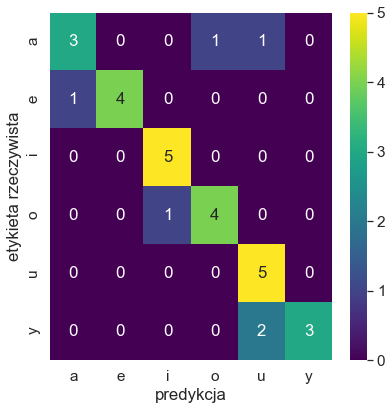

In [16]:
y_test = le.inverse_transform(y_test_enc)
y_pred = le.inverse_transform(y_pred)

# Macierz konfuzji
sns.set(font_scale=1.4)
plt.figure(figsize = (6, 6))
data = {'etykieta rzeczywista': y_test, 'predykcja': y_pred}
df = pd.DataFrame(data, columns=['etykieta rzeczywista', 'predykcja'])
confusion_mat = pd.crosstab(df['etykieta rzeczywista'], df['predykcja'], rownames=['etykieta rzeczywista'], colnames=['predykcja'])
sns.heatmap(confusion_mat, annot = True, cmap = "viridis")
plt.tight_layout()
plt.show()

In [17]:
# Macierz konfuzji
print("Macierz konfuzji:")
print(confusion_matrix(y_test, y_pred))

# Raport klasyfikacji
print('Raport klasyfikacji')
print(classification_report(y_test, y_pred))

Macierz konfuzji:
[[3 0 0 1 1 0]
 [1 4 0 0 0 0]
 [0 0 5 0 0 0]
 [0 0 1 4 0 0]
 [0 0 0 0 5 0]
 [0 0 0 0 2 3]]
Raport klasyfikacji
              precision    recall  f1-score   support

           a       0.75      0.60      0.67         5
           e       1.00      0.80      0.89         5
           i       0.83      1.00      0.91         5
           o       0.80      0.80      0.80         5
           u       0.62      1.00      0.77         5
           y       1.00      0.60      0.75         5

    accuracy                           0.80        30
   macro avg       0.83      0.80      0.80        30
weighted avg       0.83      0.80      0.80        30



## Wnioski
Dokładność predykcji wyniosła 80.00 %. Jak na klasyfikację wieloklasową z uwzględnieniem 6 klas dokładność może zostać uznana za wysoką. Samogłoska o największej liczbie prawidłowych rozpoznań to 'i'. Wszystkie jej rozpoznania były prawidłowe. Najmniejszą skuteczność zaobserwowano w przypadku rozpoznawania samogłoski 'a'.

## Przydatne linki
Selekcja cech:
https://scikit-learn.org/stable/modules/feature_selection.html
Kodowanie cech:
https://machinelearningmastery.com/how-to-prepare-categorical-data-for-deep-learning-in-python/
https://scikit-learn.org/stable/modules/preprocessing_targets.html